Project Title:
Efficient Data Stream Anomaly Detection

Project Description:
Your task is to develop a Python script capable of detecting anomalies in a continuous data stream. This stream, simulating real-time sequences of floating-point numbers, could represent various metrics such as financial transactions or system metrics. Your focus will be on identifying unusual patterns, such as exceptionally high values or deviations from the norm.

Objectives:

- **Algorithm Selection**: Identify and implement a suitable algorithm for anomaly detection, capable of adapting to concept drift and seasonal variations.
- **Data Stream Simulation**: Design a function to emulate a data stream, incorporating regular patterns, seasonal elements, and random noise.
- **Anomaly Detection**: Develop a real-time mechanism to accurately flag anomalies as the data is streamed.
- **Optimization**: Ensure the algorithm is optimized for both speed and efficiency.
- **Visualization**: Create a straightforward real-time visualization tool to display both the data stream and any detected anomalies.
Requirements:

The project must be implemented using Python 3.x.

Your code should be thoroughly documented, with comments to explain key sections.

Include a concise explanation of your chosen algorithm and its effectiveness.

Ensure robust error handling and data validation.

Limit the use of external libraries. If necessary, include a requirements.txt file.

### References 
- [An Anomaly Detection Approach Based on Isolation Forest for Streaming Data Using Sliding Window (Ding & Fei, 2013)](https://www.sciencedirect.com/science/article/pii/S1474667016314999?via%3Dihub) [1]
- [Isolation Forest (Liu, Ting, & Zhou, 2011)](https://www.researchgate.net/publication/224384174_Isolation_Forest) [2]
- [Anomaly Detection for Data Streams Based on Isolation Forest using Scikit-multiflow](https://hal.science/hal-02874869v2/file/IForestASD_ScikitMultiflow_Version2_PourHAL.pdf) [3]
- [Review of Anomaly Detection Algorithms for Data Streams](https://doi.org/10.3390/app13106353) [4]
- [Concept Drift blog post](https://neptune.ai/blog/concept-drift-best-practices) [5]
- [iForestASD code reference](https://github.com/MariamBARRY/skmultiflow_IForestASD/tree/master) [6] 

# Anomaly detection for streaming data
    Anomaly detection has many definations 
    
    Anomaly detection, or outlier detection, is an activity for finding the patterns in dataset which do not conform to the expected pattern or deviates from the expected behavior greatly. Anomaly detection is of great significance in many applications and there are many different methods available for outlier detection so far. [1]
    
    Anomalies are data patterns that have different data characteristics from normal instances. The detection of anomalies has significant relevance and often provides critical actionable information in various application domains [2]

    But mainly it is a process of identifying data points, events, or observations that deviate significantly from the norm or expected pattern in a dataset

## Installing dependencies

In [1]:
# need this for plotting 
!pip install matplotlib 

In [2]:
# need this for implementing our model
!pip install scikit-learn 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.animation import FuncAnimation
from sklearn.ensemble import IsolationForest

## Data Stream Simulation (derived from chatgpt.com)
    
Simulating a streaming data scenario by generating synthetic data with the following components:

1. **Regular Pattern (Sine Wave)**: This simulates a periodic pattern in the data stream, resembling real-world signals that exhibit cyclic behavior (e.g., seasonality in time series).
2. **Seasonal Elements**: We introduce a slower sine wave to mimic a longer-term seasonal variation that exists on top of the regular pattern.
3. **Random Noise**: Gaussian noise is added to simulate random variations commonly present in real-world data, making the stream more realistic and challenging for anomaly detection.
4. **Injected Anomalies**: Random spikes or deviations are occasionally introduced to simulate real anomalies in the data stream. These anomalies represent rare, extreme events that the iForestASD algorithm aims to detect.

The `generate_data_stream` function generates the simulated data stream in real-time. 

It yields one data point at a time to mimic a continuous flow of data, which is ideal for testing the streaming nature of the iForestASD model. 

- **`num_points`**: The total number of data points to generate.
- **`seasonality_period`**: The period of the sine wave, representing regular cyclic behavior. This can be adjusted to simulate different frequencies of regular patterns.
- **`anomaly_rate`**: The probability of injecting an anomaly. This determines how often anomalies occur in the data stream.
- **`noise_level`**: The standard deviation of the Gaussian noise. Higher noise levels simulate more random variation in the data, making anomaly detection more challenging.

#### Continuous Data Stream:
By using a generator function (`yield`), we simulate the continuous nature of the data stream. This allows the iForestASD model to process the data incrementally, updating its anomaly detector as new data points arrive. Later we will use `next()` to obtain the value from the function.

In [4]:
# Generator function to simulate a continuous data stream
def continuous_data_stream(seasonality_period=200, anomaly_rate=0.03, noise_level=0.1):
    """
    Continuously generates a simulated data stream with regular patterns, seasonal elements, and random noise.
    
    Args:
        seasonality_period (int): The period of the seasonal component.
        anomaly_rate (float): Probability of an anomaly in the data.
        noise_level (float): The standard deviation of the noise.
    
    Yields:
        float: A single data point in the stream.
    """
    
    # Time index, continuously increasing
    t = 0
    
    while True:
        # Regular pattern (sine wave)
        regular_pattern = np.sin(2 * np.pi * t / seasonality_period)

        # Seasonal element (a slower sine wave, simulating seasonal change)
        seasonal_pattern = 0.5 * np.sin(2 * np.pi * t / (seasonality_period * 5))

        # Random noise
        noise = np.random.normal(0, noise_level)

        # Combine regular, seasonal, and noise components
        data_point = regular_pattern + seasonal_pattern + noise

        # Occasionally add anomalies (random spikes)
        if random.random() < anomaly_rate:
            data_point += random.uniform(5, 10)  # Inject an anomaly (a large spike)

        # Yield the data point to simulate continuous streaming
        yield data_point

        # Increment time index
        t += 1


## Model Training

We will be using the model utilized in the following research paper *An Anomaly Detection Approach Based on Isolation Forest for Streaming Data Using Sliding Window (Ding & Fei, 2013)*  [[1]](https://www.sciencedirect.com/science/article/pii/S1474667016314999?via%3Dihub)

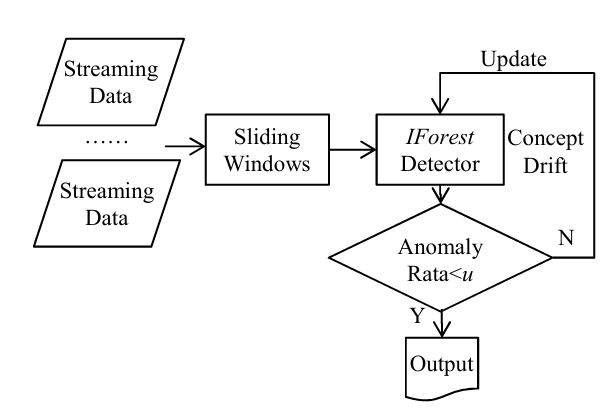

Figure 1 : Model in use 

---

Before implementing this, we will first understand the original Isolation Forest model(since it is built on that research paper), which is presented in *Isolation Forest (Liu, Ting, & Zhou, 2011)* [[2]](https://www.researchgate.net/publication/224384174_Isolation_Forest)

https://youtu.be/OS9xRGKfx4E?si=3ZgP8wBQr8yCVmlN&t=227

#### Key Concepts:
- Works by isolating attributes, partitioning of instances are repeated recursively until all instances are isolated 
- The algorithm builds an ensemble of of iTrees (or Isolation Trees) for a given data set.
- For each partition it creates an iTree
- Thus anomalies are those instances which have short average path lengths. Since : -
    - fewer the instances of anomalies result in a smaller number of partitions thus shorter paths in tree structure 
    - instances with distinguishable attribute-values are more likely to be separated in early partitioning

    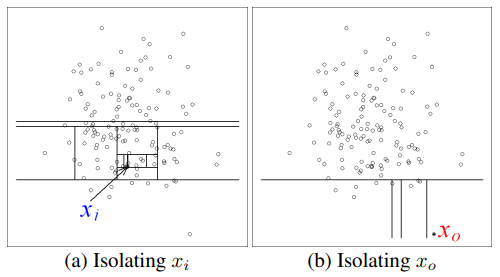

#### Why use this ?
- iForest utilizes no distance/density measures to detect anomalies, thus eliminates major computational cost
- Linear time complexity with a low constant & a low memory requirement
- Has the capacity to scale up to handle extremely large data size & high-dimensional problems with a large number of irrelevant attributes
- Has a unique way of handling the effects of swamping & masking (refer the figure 2)
- Contrary to existing methods where large sampling size is more desirable, isolation method works best when the sampling size is kept small

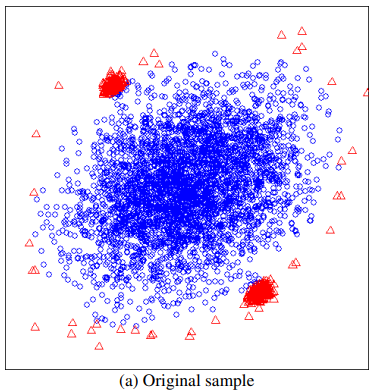  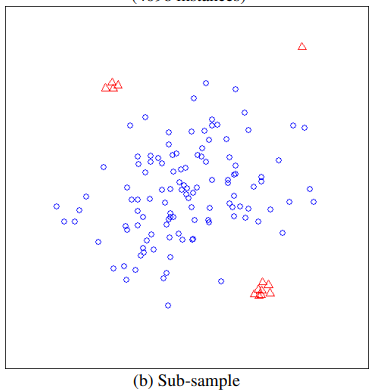

Figure 2: Sub-sampling, which controls data size & helps it better isolate examples of anomalies [[2]](https://www.researchgate.net/publication/224384174_Isolation_Forest)

#### Algorithm 
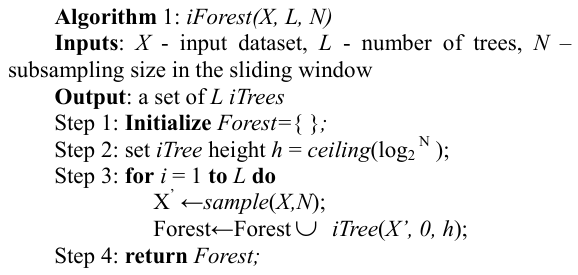  

from [[1]](https://www.sciencedirect.com/science/article/pii/S1474667016314999?via%3Dihub)


Note: We will be using the model available directly from the Scikit-learn library at "https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html" as this implementation offers a highly efficient version of the Isolation Forest algorithm, optimized for anomaly detection.

Thus : -
- `t` -> `n_estimators`
- `ψ` -> `sample size`


In [10]:
# model = IsolationForest(n_estimators=100, contamination='0.02', random_state=42)
"""
n_estimators = 100 # "We find that path lengths usually converge well before t = 100" [2] page 7
contamination = 0.02 # Percentage of outliers in the data, since the anomaly rate is set to 0.03 so any value less than it
random_state = 42 # Controls the pseudo-random number generation for selecting features and split values during the tree-building process
"""

'\nn_estimators = 100 # "We find that path lengths usually converge well before t = 100" [2] page 7\ncontamination = 0.02 # Percentage of outliers in the data, since the anomaly rate is set to 0.03 so any value less than it\nrandom_state = 42 # Controls the pseudo-random number generation for selecting features and split values during the tree-building process\n'

Overview of our model [[1]](https://www.sciencedirect.com/science/article/pii/S1474667016314999?via%3Dihub)

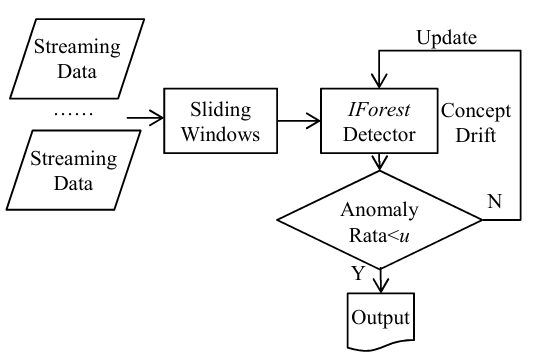

--- 
The research paper *An Anomaly Detection Approach Based on Isolation Forest for Streaming Data Using Sliding Window (Ding & Fei, 2013) [[1]](https://www.sciencedirect.com/science/article/pii/S1474667016314999?via%3Dihub)* proposed an anomaly detection framework, an adapted algorithm, namely iForestASD, is present which is modified by the iForest algorithm and suited for anomaly detection for streaming data. 

IForestASD uses sliding window to deal with streaming data. [[4]](https://doi.org/10.3390/app13106353)

IForestASD method can also deal with concept drift in the data stream by maintaining one input desired anomaly rate (u) [[4]](https://doi.org/10.3390/app13106353)

In the research paper [[1]](https://www.sciencedirect.com/science/article/pii/S1474667016314999?via%3Dihub) : -
- Streaming data is fed into the sliding window
     - Z = {z(1) , z(2) , . . . , z(t) , z(t + 1) , . . .}
     - The streaming training data set Z is divided into the data blocks having the same time interval and the same number of instances in a data block, which are named as window data block
     - Z = {Z₁, Z₂, ....Zᵢ,...} with the follow forms:
         - Z₁ = z(1), z(2), ..., z(M)
         - Z₂ = z(M + 1), z(M + 2), ..., z(2M)
         - Zᵢ = z((i - 1)M + 1), z((i - 1)M + 2), ..., z(i * M)
     - Where M denotes the size of the sliding window, Zi the ith streaming data block
- Based on the several windows data, an initial detector is trained based on the iForest algorithm
- In the test stages, every instance in sliding window is examined by the anomaly detector to judge whether it is an anomaly point or not based on the anomalous score of instance.
- After the instances in one sliding windows are completed, the statistic result is acquired, if the anomaly rate in a sliding window data is less than the predefined threshold u, then the concept drift [[5]](https://neptune.ai/blog/concept-drift-best-practices) does not happen, the trained anomaly detector will not 
change
- Otherwise, it implied that the concept drift [[5]](https://neptune.ai/blog/concept-drift-best-practices) is occurred and the trained anomaly detector need to modify and retrain

#### Algorithm in the research paper
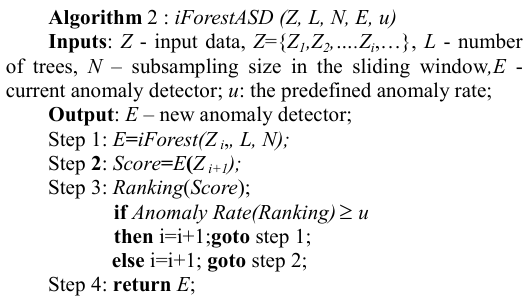

Similar to the above we are going to implement the same but here the difference is instead of storing all windows of streaming data rather store just the current & previous windows (Zi & Zi+1) since that is our concern only thus saves some memory space 

We implement a iForestASD class that does roughly what the above algorithm says 

https://youtu.be/RUfVVOhihEA?si=RoRaGkOcx_YoFLkt&t=2443

Sudo code : - 

    - Let the data_stream_function generate one float number at time.
    - Using the `yield` & `next` keep on adding the float numbers into a data structure till size = M (size of window)
    - Once the window is formed we move to the implementation steps of above algorithm 
    - Since the algorithm require two windows, we will just train the model using the first window (step 1) & wait for the formation of second one
    - After the two windows are formed/new window is formed 
    - Get scores (step 2) 
    - Calculate the anomaly rate (step 3) & check with threshold (u)/ drift threshold
        if yes : retrain the model, go to next window (i = i + 1) [does step 1 & goes to step 2]
        if no : go to next window (i = i + 1) [goes step 2]


In [13]:
class iForestASD:
    def __init__(self):
        """
        Initializes the IsolationForestStream.

        Parameters:
        - window_size: int, size of the sliding window.
        - n_estimators: int, number of trees in the Isolation Forest.
        - drift_threshold: float, threshold for drift detection to retrain the model.
        """

        # self is necessary for the attributes to be accessible in other methods
        self.window_size = 100 # M, size of Zi
        self.n_estimators = 25 # Number of trees in the Isolation Forest [6]
        self.drift_threshold = 0.95 # Threshold to detect drift, ideally 0.5 [6]
        self.model = None 
        self.prev_window = [] # Zi
        self.current_window = [] # Zi+1
        self.anomalies_x = []  # to store the x-coordinate of the anomalies(time)
        self.anomalies_y = []  # to store the y-coordinate of the anomalies(value)

    # E = iForest(Zi, L, N)
    def fit(self, data):
        """
        Fits the Isolation Forest model on the provided data.

        Parameters:
        - data: array-like of shape (n_samples, n_features)
        """
        self.model = IsolationForest(n_estimators=self.n_estimators, contamination=0.02, random_state=42)
        self.model.fit(data)
        print("Model trained on new window.")

    # Score = E(Zi+1)
    def score(self, data):
        """
        Scores the data using the fitted Isolation Forest model.

        Parameters:
        - data: array-like of shape (n_samples, n_features)

        Returns:
        - scores: array of shape (n_samples,), anomaly scores. The negative scores are anomalies.
        """
        return self.model.decision_function(data)

    def update_model(self, data):
        """
        Retrains the Isolation Forest model, typically after detecting drift.

        Parameters:
        - data: array-like of shape (n_samples, n_features)
        """
        print("Drift detected! Retraining model...")
        self.fit(data)

    def process_stream(self, data_stream):
        """
        Processes the continuous data stream, detects anomalies, and visualizes the results.

        Parameters:
        - data_stream: generator, the continuous data stream.
        """

        # Standard boilerplate code for plotting
        fig, ax = plt.subplots()
        xdata, ydata = [], []
        ln, = ax.plot([], [], 'b-', label='Data Stream') # ln is the data stream line
        anomaly_points, = ax.plot([], [], 'ro', label='Anomalies') # anomaly_points are the anomalies

        ax.set_xlim(0, self.window_size) 
        ax.set_ylim(-3, 13) # why -3 and 12 ?
        # max value of data stream = +1(regular) + 0.5(seasonal) + 0.3(noise) + 10(anomaly) ≈ +12.8 
        # min value of data stream = -1(regular) - 0.5(seasonal) - 0.3(noise) ≈ -1.8 (since anomaly is taken positive here no need to add it)
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.legend(loc='upper right')

        def update_plot(frame):
            new_data = next(data_stream)
            self.current_window.append(new_data)
            xdata.append(frame)
            ydata.append(new_data)

            # Once the current window reaches the size limit, fit and score
            if len(self.current_window) == self.window_size:
                current_window_reshaped = np.array(self.current_window).reshape(-1, 1) # Why reshape ?
                # Since scikit-learn model isolation Forest expects  expects the input to be a 2D array where: 
                #   Each row represents a sample. 
                #   Each column represents a feature.
                #   Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
                #   Reference: https://www.w3schools.com/python/numpy/numpy_array_reshape.asp

                # Will be executed only once, when the first window is processed
                if not self.model:
                    # Initial training on the first window
                    self.fit(current_window_reshaped)

                    # Score the current window based on the previously fitted model
                    scores = self.score(current_window_reshaped)

                    # Identify anomalies
                    anomalies = scores < 0
                    anomaly_indices = np.where(anomalies)[0]

                    # Record anomalies for plotting,
                    for idx in anomaly_indices:
                        anomaly_x = xdata[-self.window_size + idx]
                        anomaly_y = ydata[-self.window_size + idx]
                        self.anomalies_x.append(anomaly_x)
                        self.anomalies_y.append(anomaly_y)

                else:
                    # Score the current window based on the previously fitted model
                    scores = self.score(current_window_reshaped)

                    # Identify anomalies
                    anomalies = scores < 0  # Anomalies have negative scores
                    anomaly_indices = np.where(anomalies)[0]

                    # Record anomalies for plotting, 
                    for idx in anomaly_indices:
                        anomaly_x = xdata[-self.window_size + idx]
                        anomaly_y = ydata[-self.window_size + idx]
                        self.anomalies_x.append(anomaly_x)
                        self.anomalies_y.append(anomaly_y)

                    # Calculate anomaly rate
                    self.anomaly_rate = np.mean(anomalies)
                    print(f"Anomaly rate: {self.anomaly_rate:.2f}")

                    # If anomaly rate exceeds drift threshold, update the model
                    if self.anomaly_rate >= self.drift_threshold:
                        self.update_model(current_window_reshaped)

                # i = i+1 step
                self.prev_window = self.current_window.copy()
                self.current_window = []

            # Update plot data
            ln.set_data(xdata, ydata)
            anomaly_points.set_data(self.anomalies_x, self.anomalies_y)

            # Dynamically adjust x-axis
            if len(xdata) > self.window_size:
                ax.set_xlim(xdata[-self.window_size], xdata[-1])
            else:
                ax.set_xlim(0, self.window_size)

            return ln, anomaly_points

        # Create the animation
        ani = FuncAnimation(fig, update_plot, frames=np.arange(0, 100000), blit=True, interval=100)
        plt.show()

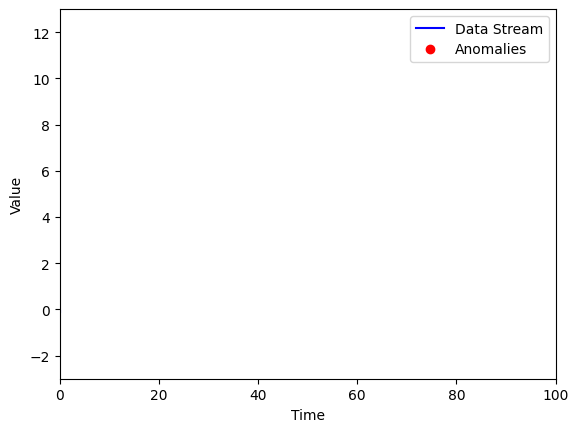

In [14]:
# NOTE : The program may not work here since Jupyter Notebooks handle plotting differently than standalone Python scripts, 
# and certain configurations are required for the animation to work correctly in notebooks, thus request you to run
# the attached python script to check the output

stream_processor = iForestASD()
data_stream = continuous_data_stream()
stream_processor.process_stream(data_stream)

However the model works well & marks the anomalies accurately unless there is no concept drift.

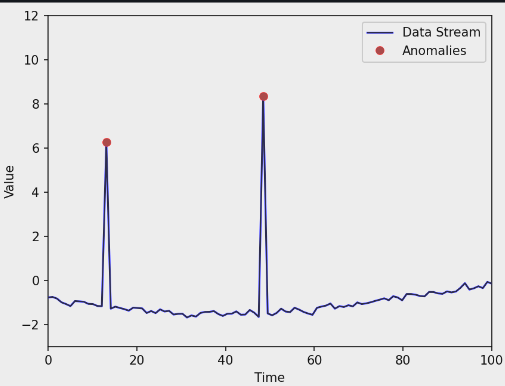

(Without concept drift)

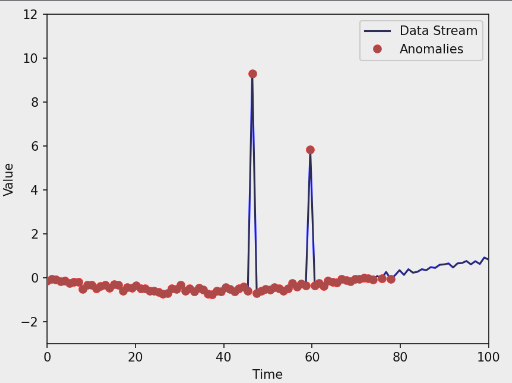

(As soon as concept drift happens)

### Understanding why this happens 
When concept drift occurs, and the anomaly rate in your data increases (e.g., to 80%), but your model is still set with a fixed low contamination rate (e.g., 3%), the model will interpret a larger portion of the data as anomalies. This mismatch causes normal points to be incorrectly labeled as anomalies.

Additionally, retraining the model on a window that includes a high proportion of anomalies can further exacerbate this issue, as the model might internalize these anomalies as part of the "normal" data distribution

### Solution
The solution is still pending. Due to time constraints, I have omitted this section and submitted the code above. The chances of a `concept_drift` is lesser with this data_stream function due to fixed parameters, still the `drift_threshold` has been configured accordingly, which elimates any chance of concept drift.

- Setting the contamination to 'auto' doesn't help instead worse it marks normal points as anomalous even if there is no concept drift